In [148]:
import pathlib
import numpy as np 
import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

In [149]:
data_dir = "C:\\Users\\Welcome\\Desktop\\ml\\Tensorflow\\Leaf-Classification\\Code\\plantvillage dataset\\color"
data_dir = pathlib.Path(data_dir)
print(data_dir)

C:\Users\Welcome\Desktop\ml\Tensorflow\Leaf-Classification\Code\plantvillage dataset\color


In [150]:
total_image = len(list(data_dir.glob('*/*.jpg')))
print(total_image)

54303


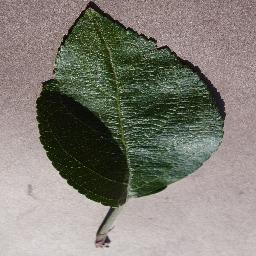

In [151]:
apple_leaves_healthy = list(data_dir.glob('Apple___healthy/*'))
PIL.Image.open(str(apple_leaves_healthy[0]))

In [152]:
batch_size = 32
img_h = 180
img_w = 180
img_size = (img_h, img_w)

In [153]:
train_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    subset='training',
    validation_split=0.3,
    seed=123,
    batch_size=batch_size,
    image_size=(img_h, img_w),
)

Found 54305 files belonging to 38 classes.
Using 38014 files for training.


In [154]:
val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    subset='validation',
    validation_split=0.3,
    seed=123,
    batch_size=batch_size,
    image_size=(img_h, img_w),
)

Found 54305 files belonging to 38 classes.
Using 16291 files for validation.


In [155]:
print(train_ds.element_spec)

(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [156]:
class_names = train_ds.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

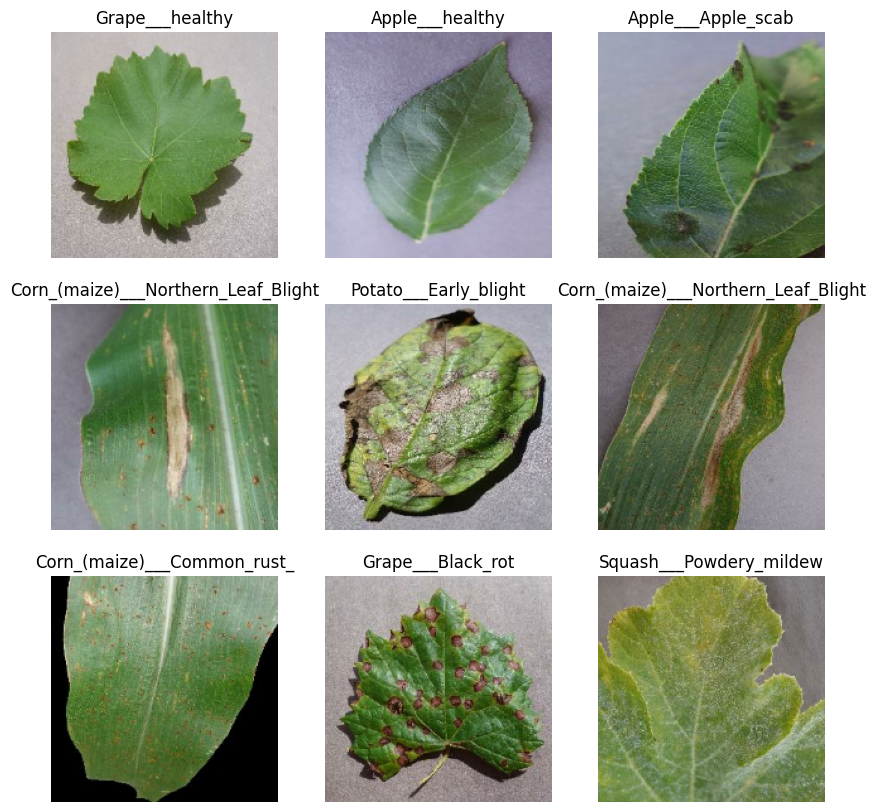

In [157]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [158]:
val_batches = tf.data.experimental.cardinality(val_ds)
print(val_batches)

tf.Tensor(510, shape=(), dtype=int64)


In [159]:
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [160]:
total_classes = len(class_names)
print(total_classes)

38


In [161]:
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, total_classes)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, total_classes)))

In [162]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [163]:
data_augmentation = Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.2),
    ]
)

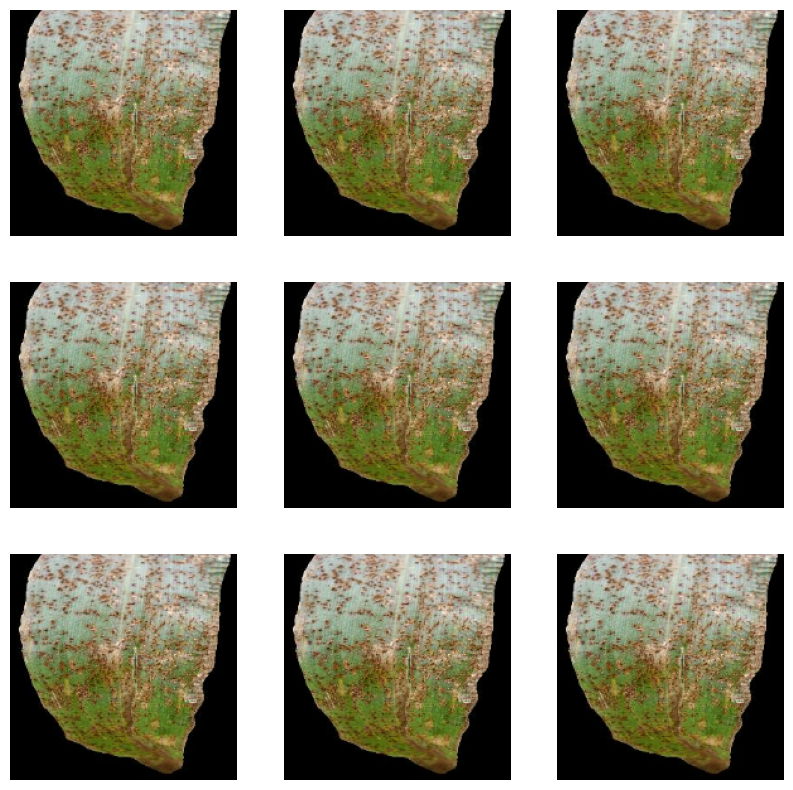

In [164]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    first_image = images[0]
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_image[0].numpy().astype('uint8'))
        plt.axis('off')

In [165]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [166]:
rescale = layers.Rescaling(1./127.5, offset=-1)

In [167]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_h, img_w, 3),
                                               include_top=False,
                                               weights='imagenet')

In [168]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [169]:
base_model.trainable = False

In [170]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_19[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][

In [171]:
global_average_layer = layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [172]:
prediction_layer = layers.Dense(38, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 38)


In [173]:
inputs = keras.Input(shape=(img_h, img_w, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = keras.Model(inputs, outputs)

In [174]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv_7 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_7 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                           

In [177]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

In [178]:
epochs = 20
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds)

Epoch 1/20
1188/1188 [==============================] - 268s 223ms/step - loss: 1.3869 - accuracy: 0.6375 - val_loss: 0.7189 - val_accuracy: 0.8247
Epoch 2/20
1188/1188 [==============================] - 172s 145ms/step - loss: 0.6656 - accuracy: 0.8221 - val_loss: 0.4824 - val_accuracy: 0.8771
Epoch 3/20
1188/1188 [==============================] - 169s 142ms/step - loss: 0.5017 - accuracy: 0.8611 - val_loss: 0.3883 - val_accuracy: 0.8974
Epoch 4/20
1188/1188 [==============================] - 164s 138ms/step - loss: 0.4186 - accuracy: 0.8805 - val_loss: 0.3374 - val_accuracy: 0.9074
Epoch 5/20
1188/1188 [==============================] - 165s 139ms/step - loss: 0.3675 - accuracy: 0.8935 - val_loss: 0.3044 - val_accuracy: 0.9159
Epoch 6/20
1188/1188 [==============================] - 164s 138ms/step - loss: 0.3348 - accuracy: 0.9014 - val_loss: 0.2786 - val_accuracy: 0.9225
Epoch 7/20
1188/1188 [==============================] - 161s 136ms/step - loss: 0.3132 - accuracy: 0.9073 - val_

ValueError: x and y must have same first dimension, but have shapes (20,) and (31,)

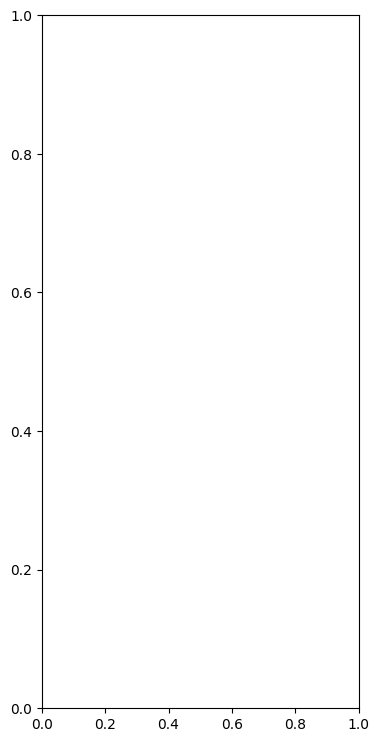

In [198]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

range_epochs = range(epochs)

plt.figure(figsize=(9, 9))
plt.subplot(1, 2, 1)
plt.plot(range_epochs, acc, label='Training Accuracy')
plt.plot(range_epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range_epochs, loss, label='Training loss')
plt.plot(range_epochs, val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()

In [180]:
base_model.trainable = True

In [181]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [184]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

In [186]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 20/30
1188/1188 [==============================] - 182s 149ms/step - loss: 0.1720 - accuracy: 0.9419 - val_loss: 0.1296 - val_accuracy: 0.9584
Epoch 21/30
1188/1188 [==============================] - 176s 148ms/step - loss: 0.1312 - accuracy: 0.9557 - val_loss: 0.1151 - val_accuracy: 0.9650
Epoch 22/30
1188/1188 [==============================] - 176s 148ms/step - loss: 0.1107 - accuracy: 0.9625 - val_loss: 0.0941 - val_accuracy: 0.9698
Epoch 23/30
1188/1188 [==============================] - 177s 149ms/step - loss: 0.0946 - accuracy: 0.9689 - val_loss: 0.0977 - val_accuracy: 0.9698
Epoch 24/30
1188/1188 [==============================] - 179s 151ms/step - loss: 0.0839 - accuracy: 0.9713 - val_loss: 0.0868 - val_accuracy: 0.9732
Epoch 25/30
1188/1188 [==============================] - 179s 151ms/step - loss: 0.0749 - accuracy: 0.9738 - val_loss: 0.0794 - val_accuracy: 0.9741
Epoch 26/30
1188/1188 [==============================] - 179s 151ms/step - loss: 0.0659 - accuracy: 0.9769

In [187]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

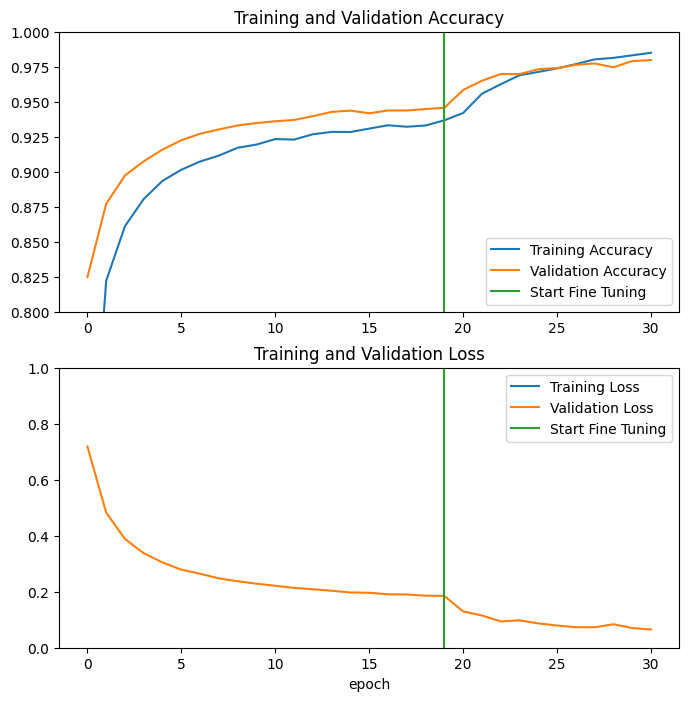

In [196]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [194]:
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, 38)))

In [195]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

102/102 [==============================] - 4s 36ms/step - loss: 0.0682 - accuracy: 0.9758
Test accuracy : 0.9757965803146362
